In [2]:
%run ./utility.ipynb

# Gradient Calculations: "Dirtying" the Image

## Method two: Dirtying the Image

Here, we use a different method of computing gradients in order to speed up the gradient calculation process. By doing so, we should also see an increase in speed for the gradient descent.

In [8]:
sample = np.loadtxt("images/data.csv", delimiter=",")
coords, data_list = do_sample(25)
emp = np.zeros((80,80))

Here we calculate gradient using some preprocessing and derivatives. We also reduce time by using a selection approach.

In [10]:
def preprocess_gradient(data_list, coords, image):
    r, c = np.shape(image)
    preprocessed = np.empty([r,c,len(data_list),2], dtype=np.complex_)
    for row in range(len(image)):
        for col in range(len(image[row])):
            for datum in range(len(data_list)):
                term = ((2*np.pi*1j)/image.size)*(row*coords[datum][0] + col*coords[datum][1]) #.size for numpy array returns # of rows * # of cols
                term_1 = np.exp(term)
                term_2 = np.exp(-1*term)
                preprocessed[row,col,datum,0] = term_1
                preprocessed[row,col,datum,1] = term_2
    return preprocessed

In [18]:
coeffs = preprocess_gradient(data_list, coords, emp)

(80, 80, 25, 2)

In [12]:
def dirty_gradient(data_list: list[data], coords, coeffs, image, subset_percent = 10, FOV = 100*u.uas.to(u.rad)):
    gradient_arr = np.empty(np.shape(image)) # Because we are in real space
    vis_images = interpolate(image, coords, FOV)
    selection = np.random.choice(np.arange(len(data_list)), size=len(coords)*subset_percent//100, replace=False) # selection is full of indicies
    for row in range(len(image)):
        for col in range(len(image[row])):
            gradient_sum = 0
            for i in selection:
                vis_data = data_list[i].vis_data
                vis_image = vis_images[i]
                term_1 = coeffs[row,col,i,0] * (np.conj(vis_image) - np.conj(vis_data))
                term_2 = coeffs[row,col,i,1] * (vis_image - vis_data)
                gradient_sum += (term_1 + term_2)/(data_list[i].sigma ** 2)
            gradient_arr[row,col] = gradient_sum
    return gradient_arr

In [41]:
def dirty_gradient_simple(data_list: list[data], coords, coeffs, image, subset_percent = 10, FOV = 100*u.uas.to(u.rad)):
    gradient_arr = np.empty(np.shape(image)) # Because we are in real space
    vis_images = interpolate(image, coords, FOV)
    # selection = np.random.choice(np.arange(len(data_list)), size=len(coords)*subset_percent//100, replace=False) # selection is full of indicies
    for row in range(len(image)):
        for col in range(len(image[row])):
            gradient_sum = 0
            for i in range(len(data_list)):
                vis_data = data_list[i][1]
                vis_image = vis_images[i]
                term_1 = coeffs[row,col,i,0] * (np.conj(vis_image) - np.conj(vis_data))
                term_2 = coeffs[row,col,i,1] * (vis_image - vis_data)
                gradient_sum += (term_1 + term_2)/(1 ** 2) # What should I set sigma to?
            gradient_arr[row,col] = gradient_sum
    return gradient_arr

/var/folders/_b/trlmhkgj5xq968yccj4vtg1c0000gn/T/ipykernel_81082/1027418742.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient_arr[row,col] = gradient_sum


(-0.5, 79.5, 79.5, -0.5)

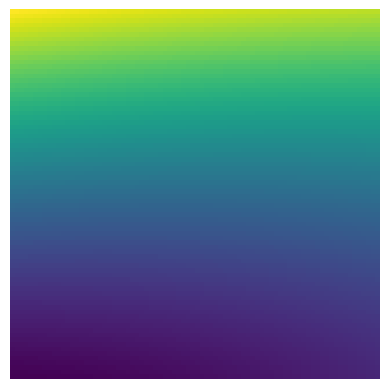

In [42]:
x = dirty_gradient_simple(data_list, coords, coeffs, emp)
plt.figure()
plt.imshow(x)
plt.axis('off')

In [35]:
def gradient_descent(image, data_list, coords, coeffs):
    image_copy = np.copy(image, subok=True) # Uses copy of the image due to lists being mutable in python
    i = 0
    grad = None
    # Can also use max here, min just makes it finish quicker
    while grad is None or np.min(np.abs(grad)) > 0.0000001:

        t = 10000000 # Initial Step size which resets each iteration
        prev_loss = simple_loss(image_copy, data_list, coords)
        grad = dirty_gradient_simple(data_list, coords, coeffs, image_copy)

        new_image = image_copy - t * grad.real
        new_loss = simple_loss(new_image, data_list, coords)
        
        while new_loss > prev_loss: # Only run when new_loss > prev_loss
            new_image = image_copy - t * grad.real
            new_loss = simple_loss(new_image, data_list, coords)
            t /= 2

        image_copy -= t * 2 * grad.real # Multiply by 2 to undo last divide in the while loop
        i += 1
        if i == 1000: # Hard stop here for notebook purposes
            return image_copy
    return image_copy

In [36]:
#x = gradient_descent(emp,data_list,coords,coeffs)

/var/folders/_b/trlmhkgj5xq968yccj4vtg1c0000gn/T/ipykernel_81082/697158430.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient_arr[row,col] = gradient_sum


(-0.5, 79.5, 79.5, -0.5)

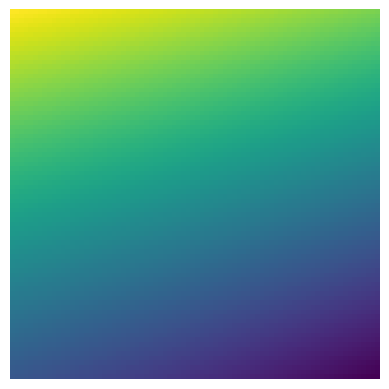

In [40]:
plt.figure()
plt.imshow(x)
plt.axis('off')